<h1><center>Pneumonia Detection</center></h1> 
<center>Mini Project</center>
<center>Prof. Predrag Radivojac, Northeastern University, Spring 2020
 </center>  
<center>Basar S. Chowdhury (chowdhury.b@husky.neu.edu),  Mayur Kurup (kurup.m@husky.neu.edu)
</center> 

---



In [0]:
## disable future warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as npNortheastern
import matplotlib.pyplot as plt
import pydicom
import pandas as pd
from glob import glob
import pylab
import os
import seaborn as sns
from matplotlib.patches import Rectangle
import csv
import random
from skimage import measure
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import gc
from skimage.transform import resize
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

## input dir
data_dir = os.path.join(os.getcwd() + '/rsna')

###Exploratory Data Analysis : EDA


In [4]:
## list all the files in the input folder
print("\n".join(os.listdir(data_dir)))


stage_2_train_labels.csv
stage_2_sample_submission.csv
stage_2_test_images
stage_2_train_images
stage_2_detailed_class_info.csv
GCP Credits Request Link - RSNA.txt


In [0]:
## load and set file/folder variables
details_class_info_csv = os.path.join(data_dir, 'stage_2_detailed_class_info.csv')
labeled_boxes_csv = os.path.join(data_dir, 'stage_2_train_labels.csv')
train_images_folder = os.path.join(data_dir, 'stage_2_train_images')
test_images = os.path.join(data_dir, 'stage_2_test_images')

In [7]:
## load the csv's as dataframe 
labled_df = pd.read_csv(labeled_boxes_csv)
print("Content of the stage_2_train_labels.csv: \n")
labled_df.head()



Content of the stage_2_train_labels.csv: 



,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [8]:

class_info_df = pd.read_csv(details_class_info_csv)
print("\n\n\nContent of the stage_2_detailed_class_info.csv:\n")
class_info_df.head()




Content of the stage_2_detailed_class_info.csv:



,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


**Description of the files:**    
`stage_2_train_labels.csv` : training set with patientId and labels    
`stage_2_sample_submission.csv`      
`stage_2_test_images` : folder containing test images    
`stage_2_train_images` : folder contaning training images     
`stage_2_detailed_class_info.csv` : contains more details about the patient and lung opacities 

In [0]:
def get_dcm_image(patientId, data_type="train"):
  '''returns the path to the corresponding patientId 
  image file path
  '''
  filepath = ''
  if data_type == 'train':
    filepath = os.path.join(data_dir, 'stage_2_train_images/%s.dcm' % patientId)
  else:
    filepath = os.path.join(data_dir, 'stage_2_test_images/%s.dcm' % patientId)

  return filepath


#### View files types, content and format

In [10]:
## viewing the individual image sample given patientId
def view_individual_patient_image(patientId, 
                                  cmap_value=pylab.cm.gist_gray):
  '''Views the individuals patients image 
  patientId : patient's id
  '''
  dcm_file = get_dcm_image(patientId)
  dcm_data = pydicom.read_file(dcm_file)
  sample_img = dcm_data.pixel_array
  pylab.imshow(sample_img, cmap=cmap_value)
  pylab.axis('off')

## view the content of the dcm file 
pid = labled_df['patientId'][4]
dcm_file = get_dcm_image(pid)
dcm_data = pydicom.read_file(dcm_file)
print("dcm_file format for patientId=4\n")
print(dcm_data)


dcm_file format for patientId=4

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '00436515-870c-4b36-a041-de91049b9ab4'
(0010, 0020) Patient ID                          LO: '00436515-870c-4b36-a041-de91049b9ab4'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                    

#### View different classes of patient images      
It will help us manually guess the what we are trying to classify and    
what approach we can take.



image of patientId=4 with class 'Lung Opacity'


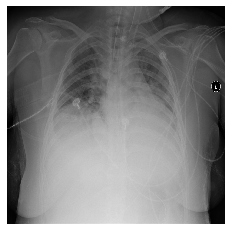

In [27]:

## view image
print("\n\nimage of patientId=4 with class 'Lung Opacity'")
view_individual_patient_image(pid)



image of patientId=1 with class 'No Lung Opacity / Not Normal'


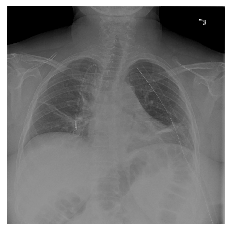

In [319]:
print("\n\nimage of patientId=1 with class 'No Lung Opacity / Not Normal'")
view_individual_patient_image(labled_df['patientId'][1])




image of patientId=3 with class 'Normal'


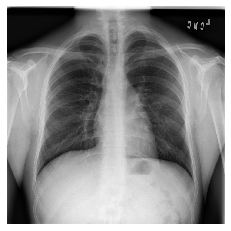

In [166]:
print("\n\nimage of patientId=3 with class 'Normal'")
view_individual_patient_image(labled_df['patientId'][3])



image of patientId=2 with class 'No Lung Opacity / Not Normal'


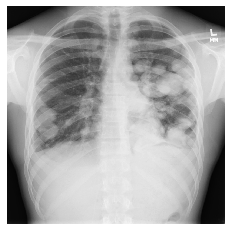

In [167]:
print("\n\nimage of patientId=2 with class 'No Lung Opacity / Not Normal'")
view_individual_patient_image(labled_df['patientId'][2])



image of patientId=38 with class 'No Lung Opacity / Not Normal'


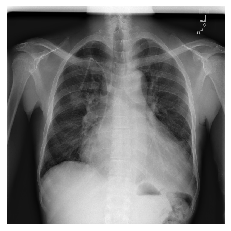

In [214]:
print("patient with heart condition")
print("\n\nimage of patientId=38 with class 'No Lung Opacity / Not Normal'")
view_individual_patient_image(labled_df['patientId'][38])

                                  patientId     x      y  width  height  \
14879  924f4f8b-fc27-4dfd-b5ae-59c40715e150  85.0  215.0  378.0   681.0   

       Target  
14879       1  


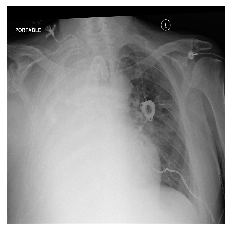

In [222]:
## missing half lung
pid_missing = box_df.loc[box_df['patientId'] == "924f4f8b-fc27-4dfd-b5ae-59c40715e150"]
print(pid_missing)
view_individual_patient_image(labled_df['patientId'][14879])

**Check missing values**

In [241]:
def missing_data(data):
  '''
  '''
  total = data.isnull().sum().sort_values(ascending = False)
  percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
  return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))

## check for missing data 'stage_2_train_labels'
missing_data(labled_df)

,height,width,y,x,Target,patientId
Total,20672.000000,20672.000000,20672.000000,20672.000000,0.0,0.0
Percent,68.389188,68.389188,68.389188,68.389188,0.0,0.0


In [242]:
## check for missing data in stage_2_detailed_class_info
missing_data(class_info_df)

,class,patientId
Total,0.0,0.0
Percent,0.0,0.0


#### Shape of the data

Shape of stage_2_detailed_class_info.csv : (30227, 2)
Unique values : 26684




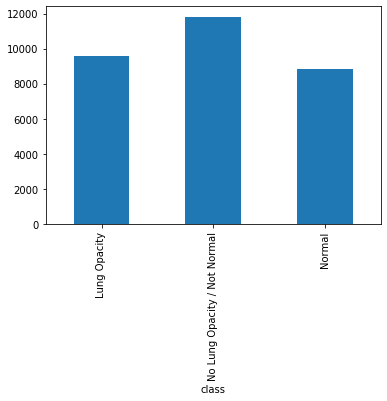

In [12]:
## view the dimensions, counts
print("Shape of stage_2_detailed_class_info.csv : {0}".format(class_info_df.shape))
print("Unique values : {0}\n\n".format(class_info_df['patientId'].value_counts().shape[0]))

## plot the distribution of classes
class_info_df.groupby('class').size().plot.bar()


Shape of stage_2_train_labels.csv.csv : (30227, 6)
Unique values : 26684




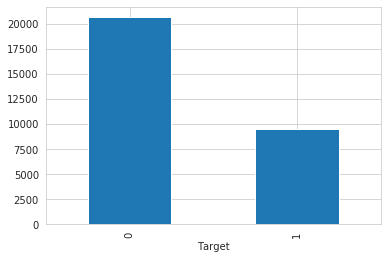

In [252]:

print("Shape of stage_2_train_labels.csv : {0}".format(labled_df.shape))
print("Unique values : {0}\n\n".format(labled_df['patientId'].value_counts().shape[0]))
## plot the distribution of classes
labled_df.groupby('Target').size().plot.bar()

In [54]:
## train
print("Total image files in 'stage_2_train_images' : {0}".format(len(os.listdir(train_images_folder))))


Total image files in 'stage_2_train_images' : 26684


Total no. of image files in 'stage_2_train_images' : `26684`     
Total no. of records in 'stage_2_train_labels.csv' : `26684`  
Total no. of unique records in 'stage_2_detailed_class_info': `26684`     


They are consistent with each other !!

#### View the distribution of 3 different types of classes 


In [14]:
merged_df = labled_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')
print(merged_df.shape)
print("unique values in merged dataframe : {0}".format(len(merged_df['patientId'].unique())))
merged_df.sample(5)



(37629, 7)
unique values in merged dataframe : 26684


,patientId,x,y,width,height,Target,class
7855,49467153-bfcf-4d73-be8c-54dd133771c0,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
13192,6fd0d3d2-a990-41a8-b843-94d2356afe42,355.0,360.0,202.0,411.0,1,Lung Opacity
37125,27aa5880-422d-4084-b907-409754c89713,NaN,NaN,NaN,NaN,0,Normal
20785,a1dc7fe9-1e55-4956-9f04-f99f624faefb,NaN,NaN,NaN,NaN,0,Normal
35254,fbbd1c86-6545-4cf7-8273-0c77161c847c,NaN,NaN,NaN,NaN,0,Normal


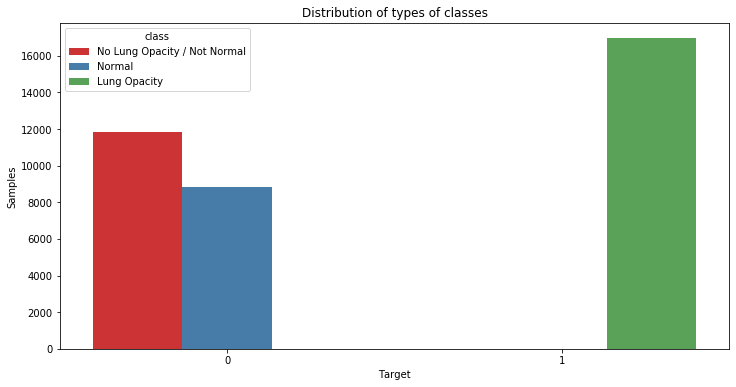

In [15]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = merged_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Samples': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Samples',hue='class',data=df, palette='Set1')
plt.title("Distribution of types of classes")
plt.show()

#### Combine both the csv 

In [11]:
combined_df = pd.merge(labled_df, class_info_df, how='inner', on='patientId')
print(combined_df.shape[0], 'combined cases')

37629 combined cases


In [0]:
# combined_df = pd.concat([labled_df, 
#                         class_info_df.drop('patientId',1)], 1)
# print(combined_df.shape[0], 'combined cases')
# combined_df.sample(10)
combined_svm_df = combined_df.copy()


#### Find lungs opacity intervals

We will filter out all the records with box values so that we can   
plot the ranges of the box. This will give us an vague idea of the localization of the target boxes for opacity.

In [13]:
final = combined_df.dropna()  ## this will filter all the records only with boxes
print(final.shape[0], 'combined cases')
final.sample(5)

16957 combined cases


,patientId,x,y,width,height,Target,class
27024,c10053b8-7bc8-4d8f-99f0-92d86a97ee2e,680.0,372.0,179.0,319.0,1,Lung Opacity
6822,41abed8d-8781-4564-b0cc-9d4abbfcad5f,231.0,538.0,161.0,204.0,1,Lung Opacity
22801,ad89c871-f23f-40a2-a39e-53db93884b59,220.0,301.0,201.0,397.0,1,Lung Opacity
4875,3874e3f6-0c79-4fc1-a874-1d761e475e53,336.0,413.0,171.0,368.0,1,Lung Opacity
3006,2d09d0bb-a4fb-4a50-99c4-496ad756533e,199.0,663.0,188.0,70.0,1,Lung Opacity


<Figure size 432x288 with 0 Axes>

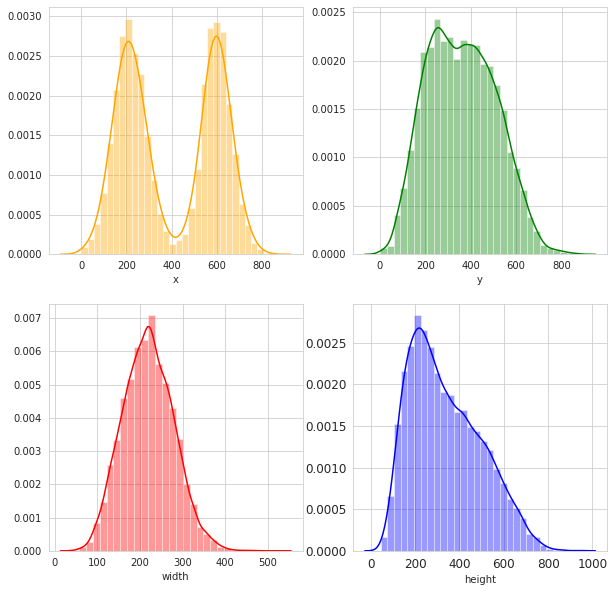

In [19]:
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(10,10))
sns.distplot(final['x'],kde=True,bins=30, color="orange", ax=ax[0,0])
sns.distplot(final['y'],kde=True,bins=30, color="green", ax=ax[0,1])
sns.distplot(final['width'],kde=True,bins=30, color="red", ax=ax[1,0])
sns.distplot(final['height'],kde=True,bins=30, color="blue", ax=ax[1,1])

locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [0]:
## Centers of rectangle

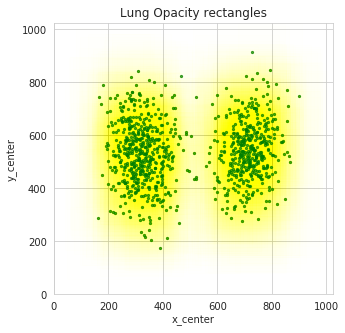

In [102]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
final1 = final.sample(1000)
final1['x_center'] = final1['x'] + final1['width'] / 2
final1['y_center'] = final1['y'] + final1['height'] / 2
plt.title("Lung Opacity rectangles")
final1.plot.scatter(x='x_center', y='y_center', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.7, marker=".", color="green")
for i, sample in final1.iterrows():
    ax.add_patch(Rectangle(xy=(sample['x'], sample['y']),
                width=sample['width'],height=sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

In [0]:
final.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,9555


In [368]:
box_df = combined_df.groupby('patientId').size().reset_index(name='boxes')
combined_df = pd.merge(combined_df, box_df, on='patientId')
box_df.groupby('boxes').size().reset_index(name='patients')

,boxes,patients
0,1,23286
1,4,3266
2,9,119
3,16,13


In [369]:
box1_df = final.groupby('patientId').size().reset_index(name='boxes1')
final = pd.merge(final, box1_df, on='patientId')
box1_df.groupby('boxes1').size().reset_index(name='patients')

,boxes1,patients
0,1,2614
1,2,3266
2,3,119
3,4,13


In [133]:
print(box_df.iloc[8])

patientId    00704310-78a8-4b38-8475-49f4573b2dbb
x                                             323
y                                             577
width                                         160
height                                        104
Target                                          1
Name: 8, dtype: object


#### View the individual images with different color maps

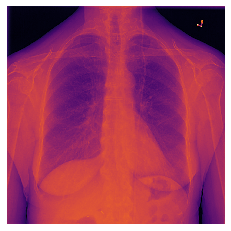

In [325]:
pid_45 = box_df['patientId'][45]
view_individual_patient_image(pid_45, cmap_value=pylab.cm.inferno)

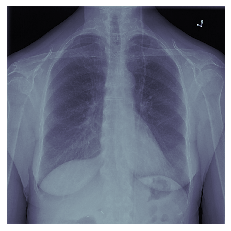

In [324]:
view_individual_patient_image(pid_45, cmap_value=pylab.cm.bone)

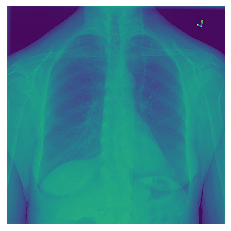

In [327]:
view_individual_patient_image(pid_45, cmap_value=pylab.cm.viridis)

In [0]:
def parse_data_dict(df):
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows(): 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': get_dcm_image(pid),
                'label': row['Target'],
                'boxes': []}

        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

In [363]:
parsed = parse_data_dict(labled_df)
print(len(parsed.keys()))

26684


In [0]:

# print(parsed['003d8fa0-6bf1-40ed-b54c-ac657f8495c5']) ## normal 
# print(parsed['00704310-78a8-4b38-8475-49f4573b2dbb']) ## opaque

#### Visualize the boxes

In [0]:
def overlay_box(pixels, box, rgb, stroke=8):
    #get integers coordinates
    box = [int(b) for b in box]
    
    #get x,y coordinates
    y1, x1, height, width = box
    y2 = y1 + height 
    x2 = x1 + width

    pixels[y1:y1 + stroke, x1:x2] = rgb
    pixels[y2:y2 + stroke, x1:x2] = rgb
    pixels[y1:y2, x1:x1 + stroke] = rgb
    pixels[y1:y2, x2:x2 + stroke] = rgb

    return pixels

def construct_boxes(image, size=(20,10)):
    '''Create boxes using the lables information of 
    boxes given in stage_2_train_labels.csv
    '''
    fig=plt.figure(figsize=size)
    d = pydicom.read_file(image['dicom'])
    pixels = d.pixel_array
    #Convert from 3d for rgb pixels
    pixels = np.stack([pixels] * 3, axis=2)

    for box in image['boxes']:
        rgb = [0,255,0]
        pixels = overlay_box(pixels=pixels, box=box, rgb=rgb, stroke=8)
    pylab.imshow(pixels, cmap=pylab.cm.viridis)
    pylab.axis('off')
    plt.show()

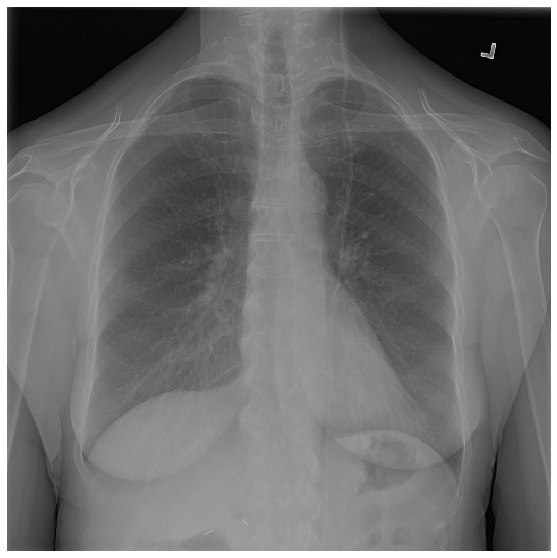

In [316]:
construct_boxes(parsed['01aad2a6-3b93-45e3-bf37-2d73348cb6fc'])

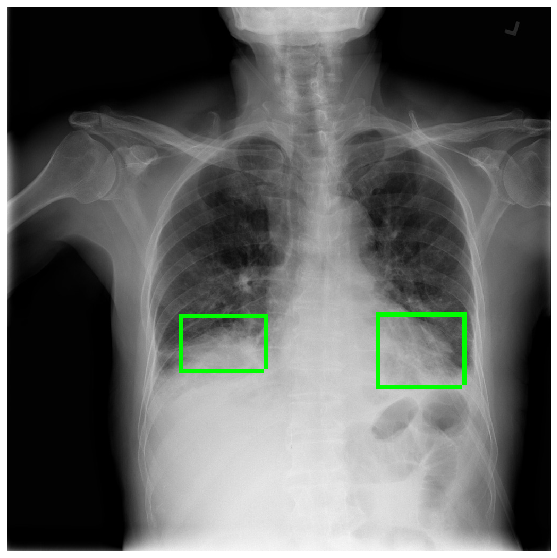

In [317]:

construct_boxes(parsed['00704310-78a8-4b38-8475-49f4573b2dbb'])

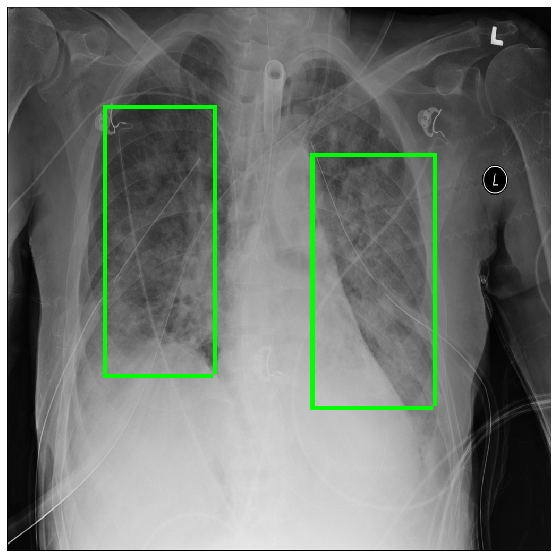

In [307]:
construct_boxes(parsed['00f08de1-517e-4652-a04f-d1dc9ee48593'])

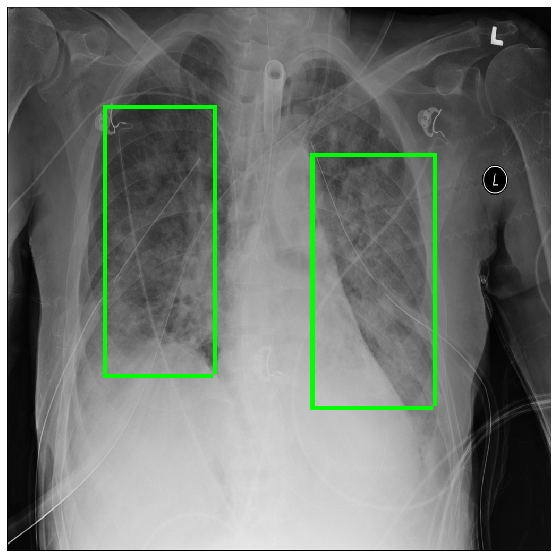

In [308]:
construct_boxes(parsed['00f08de1-517e-4652-a04f-d1dc9ee48593'])


In [20]:
pneumonia_locations = {}
# load table
with open(labeled_boxes_csv, mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

print(len(pneumonia_locations))

6012


#### Split the dataset into train and test

In [14]:
## train
filenames = os.listdir(train_images_folder)
print("Total image files in 'stage_2_train_images' : {0}".format(len(filenames)))

## test 
filenames_test = os.listdir(test_images)
print("Total image files in 'stage_2_train_images' : {0}".format(len(filenames_test)))


# split into train and test filenames by 80/20
test = int(len(filenames) * 0.2)
train = filenames[test:]
test = filenames[:test]
print('Train :', len(train))
print('Test : ', len(test))

Total image files in 'stage_2_train_images' : 26684
Total image files in 'stage_2_train_images' : 3000
Train : 21348
Test :  5336


### Convolutional Neural Network

**Data augmentations**    
Images can vary in dimensions and rotation, we need to to take care of the 
image augmentations while training. These augmentation includes the  
* Resizing 
* Rotation 
* Horizontal flips     

We will be using the `keras.utils.Sequence` and implement it to generate the data efficiently. 

In [0]:
'''Generic class to augment the image data
Referenced from official documentations 
with batch mode
'''

class Generator(keras.utils.Sequence):
    
    def __init__(self, folder, 
                 filenames, 
                 pneumonia_locations=None, 
                 batch_size=32, 
                 image_size=320, 
                 shuffle=True, 
                 augment=False, 
                 predict=False):
        self.folder = train_images_folder
        self.augment = augment
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # diacom as array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        msk = np.zeros(img.shape)
        ## discard file extension
        filename = filename.split('.')[0]

        ### if image has pnemonia target then extract the box
        if filename in pneumonia_locations:
            for location in pneumonia_locations[filename]:
                ## set '1' if it has pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        ## horizontal flip
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        ## resize
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        ## diacom as array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
    
    def __getitem__(self, idx):
        # set batch size
        filenames = self.filenames[idx*self.batch_size:(idx+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        
        ## return images and masks
        else:
            items = [self.__load__(filename) for filename in filenames]
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
            
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [0]:
BATCH_SIZE = 16
IMAGE_SIZE = 320

In [0]:
def downSample(channels, inputs):
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(inputs)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def resNet(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def myRESNET(input_size, channels, blocks=2, depth=3):
    #Input layer
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    #Residual layer
    for d in range(depth):
        channels = channels * 2
        x = downSample(channels, x)
        for b in range(blocks):
            x = resNet(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(256, 1, activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2DTranspose(128, (8,8), (4,4), padding="same", activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(64,1, padding="same", activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
    outputs = keras.layers.UpSampling2D(2**(depth-2))(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

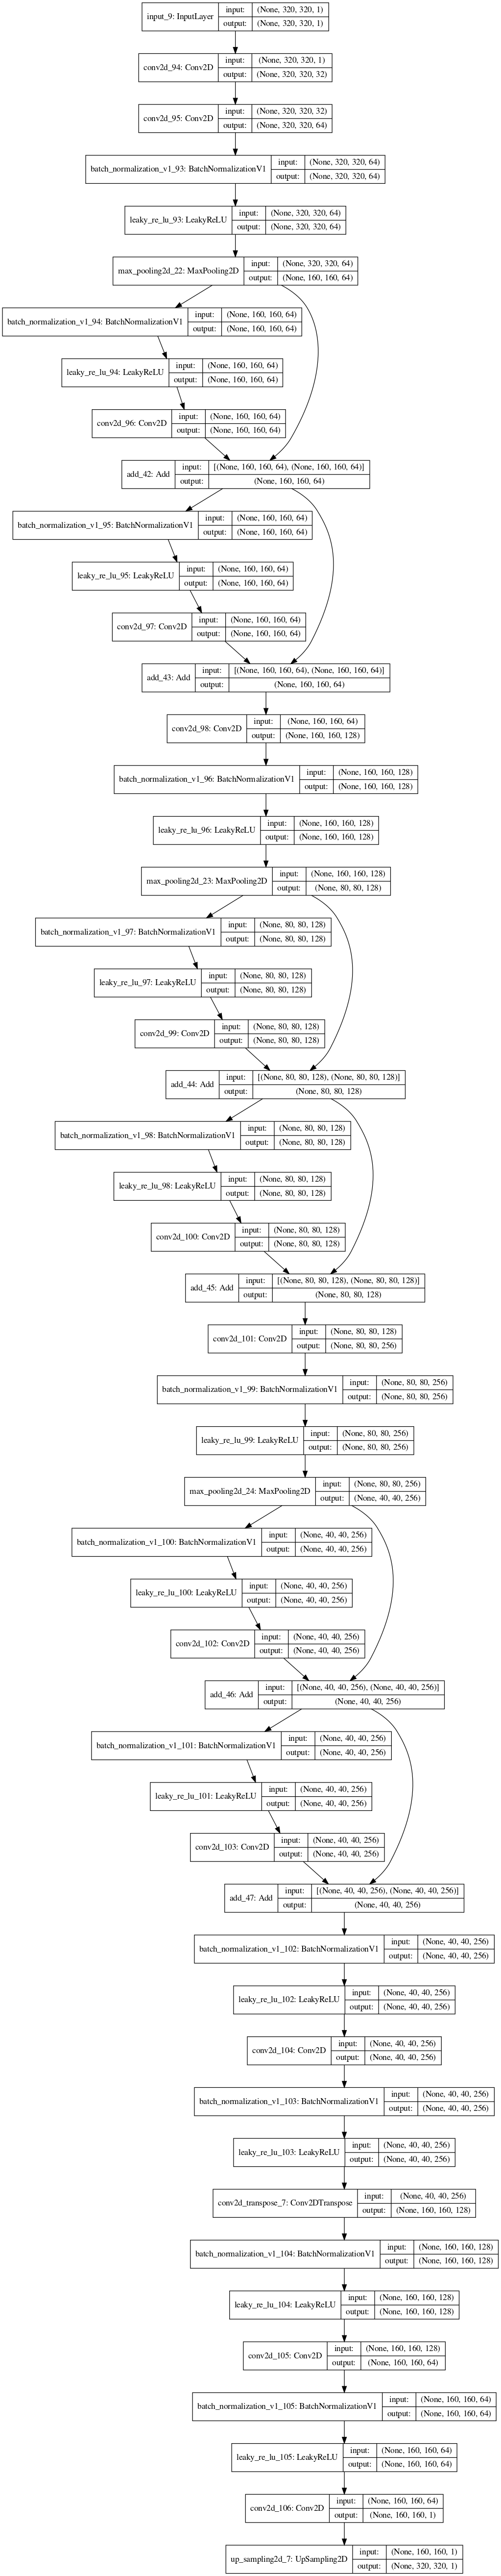

In [14]:
## plot the model
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

model = myRESNET(input_size=320, channels=32, blocks=2, depth=3)
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True, dpi=90)


In [25]:
# create network and compiler
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#annealing cosine learning
def cosine_annealing(x):
    lr = 0.002
    epochs = 15
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
train_gen = Generator(train_images_folder, train, pneumonia_locations, batch_size=16, image_size=320, shuffle=True, augment=True, predict=False)
test_gen = Generator(train_images_folder, test, pneumonia_locations, batch_size=16, image_size=320, shuffle=False, predict=False)

print(model.summary())
                                                

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 320, 320, 32) 288         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 320, 320, 64) 2048        conv2d_13[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1_13 (Batc (None, 320, 320, 64) 256         conv2d_14[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

In [0]:
myRESNET = model.fit_generator(train_gen, validation_data=test_gen, 
                               callbacks=[learning_rate], 
                               epochs=1, 
                               shuffle=True)

In [0]:
duplicate_RESNET = myRESNET

In [0]:
print(myRESNET.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [0]:
print(myRESNET.history['accuracy'])
print(myRESNET.history['val_accuracy'])


[0.97607964]
[0.96008945]


### Support vector machine 

In [0]:
## from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn import datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
import numpy as np
import pandas as pd
from numpy import interp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [16]:
combined_svm_df.shape
combined_svm_df.sample(20)
forSVMFinal_df = combined_svm_df.drop('class', axis = 1).copy()
forSVMFinal_df.sample(5)

,patientId,x,y,width,height,Target
24911,b71bca51-9eed-4780-9835-12f3245834e6,NaN,NaN,NaN,NaN,0
12251,69702abd-0555-4e3c-bb6a-f73a1d47adfd,656.0,541.0,196.0,149.0,1
27008,c04866bb-85d2-4186-8c48-3ce46dcfa80c,NaN,NaN,NaN,NaN,0
5401,3b039064-dc2b-43dc-a9d3-0edf181f523a,NaN,NaN,NaN,NaN,0
17466,8b60f253-6ae0-4b16-89bc-f3e3163dbbae,314.0,270.0,96.0,223.0,1


In [0]:
## fresh load file again and resets the variables
## load and set file/folder variables
details_class_info_csv = os.path.join(data_dir, 'stage_2_detailed_class_info.csv')
labeled_boxes_csv = os.path.join(data_dir, 'stage_2_train_labels.csv')
train_images_folder = os.path.join(data_dir, 'stage_2_train_images')
test_images = os.path.join(data_dir, 'stage_2_test_images')



In [18]:
## load the csv's as dataframe 
labled_df_tmp = pd.read_csv(labeled_boxes_csv)
print("Content of the stage_2_train_labels.csv: \n")
labled_df_tmp.head()


Content of the stage_2_train_labels.csv: 



,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [19]:
## second csv
class_info_df_tmp = pd.read_csv(details_class_info_csv)
print("\n\n\nContent of the stage_2_detailed_class_info.csv:\n")
class_info_df_tmp.head()




Content of the stage_2_detailed_class_info.csv:



,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [20]:
df = pd.merge(left = class_info_df_tmp, right = labled_df_tmp, how = 'left', on = 'patientId')

del class_info_df_tmp, labled_df_tmp
gc.collect()

df = df.drop_duplicates()
df_meta = df.drop('class', axis = 1).copy()
df_meta.sample(20)

,patientId,x,y,width,height,Target
31807,e3dca188-6311-4214-9d15-c1d4ba4dea55,694.0,488.0,99.0,342.0,1
10036,58cbbc5a-4d66-4c43-8def-b407ec2ce8a9,NaN,NaN,NaN,NaN,0
3484,32696785-8a96-4e01-977e-03559d1afd71,NaN,NaN,NaN,NaN,0
23673,b1827a4d-c98c-4719-8296-1659617870a7,NaN,NaN,NaN,NaN,0
51,019ca122-9cdf-4704-b7a9-449c8a1c263e,NaN,NaN,NaN,NaN,0
29605,d2dd6b61-572f-4d66-9a5b-05a026fa40c9,NaN,NaN,NaN,NaN,0
34251,f4fffaa6-a5b8-494e-911b-1560d1937422,212.0,350.0,197.0,339.0,1
12588,6bd01448-46f5-4ff9-aa10-ed934881427f,NaN,NaN,NaN,NaN,0
23741,b1d545f0-8658-4533-959f-dc32955904ca,NaN,NaN,NaN,NaN,0
35470,fd43dbd5-4dcb-4b62-ae2a-e991a703b48d,152.0,276.0,212.0,382.0,1


In [38]:
## if df_meta.pkl pickle is not available then run the following.
## it takes couple of hrs to parse through each file
dcm_columns = None
for n, pid in enumerate(df_meta['patientId'].unique()):
    dcm_file = get_dcm_image(pid)
    dcm_data = pydicom.read_file(dcm_file)
    
    if not dcm_columns:
        dcm_columns = dcm_data.dir()
        dcm_columns.remove('PixelSpacing')
        dcm_columns.remove('PixelData')
    
    for col in dcm_columns:
        if not (col in df_meta.columns):
            df_meta[col] = np.nan
        index = df_meta[df_meta['patientId'] == pid].index
        df_meta.loc[index, col] = dcm_data.data_element(col).value
        
    del dcm_data
    
gc.collect()

df_meta.head()


,patientId,x,y,width,height,Target,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,...,SamplesPerPixel,SeriesDescription,SeriesInstanceUID,SeriesNumber,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,,8.0,8.0,CHEST,...,1.0,view: PA,1.2.276.0.7230010.3.1.3.8323329.28530.15178744...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.28530.15178744...,000000.00,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,,8.0,8.0,CHEST,...,1.0,view: PA,1.2.276.0.7230010.3.1.3.8323329.26024.15178744...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.26024.15178744...,000000.00,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,,8.0,8.0,CHEST,...,1.0,view: AP,1.2.276.0.7230010.3.1.3.8323329.11252.15178743...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.11252.15178743...,000000.00,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,,8.0,8.0,CHEST,...,1.0,view: PA,1.2.276.0.7230010.3.1.3.8323329.2293.151787429...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.2293.151787429...,000000.00,PA
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,,8.0,8.0,CHEST,...,1.0,view: AP,1.2.276.0.7230010.3.1.3.8323329.6379.151787432...,1.0,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.6379.151787432...,000000.00,AP


In [0]:
## save to pickle so that we dont have to parse the images again
## which takes more than 2hrs
df_meta.to_pickle("./df_meta.pkl")

In [0]:
## read from pickle 
df_meta = pd.read_pickle("./df_meta.pkl")

In [23]:
print(df_meta.head())

                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


In [0]:
def get_meta_data(pid, columns):
    dicom = pydicom.read_file(get_dcm_image(pid))
    wantedColumn = getattr(dicom, columns)
    return wantedColumn

##### Adding few important columns from the image metadata. 

In [0]:
## important columns - should have some variance and distribution
columns = ['PatientSex', 'PatientAge', 'ViewPosition']
for i in columns:
    forSVMFinal_df[i] = forSVMFinal_df['patientId'].apply(lambda l: get_meta_data(l, i))
forSVMFinal_df['PatientAge'] = forSVMFinal_df['PatientAge'].apply(pd.to_numeric, errors='coerce')
forSVMFinal_df['PatientAge'] = forSVMFinal_df['PatientAge'].apply(lambda l: l if l<120 else np.nan)


In [26]:
forSVMFinal_df.head()

,patientId,x,y,width,height,Target,PatientSex,PatientAge,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,F,51.0,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,F,48.0,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,M,19.0,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,M,28.0,PA
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,F,32.0,AP


In [0]:
svmDuplicate_df = forSVMFinal_df

In [28]:
svmDuplicate_df.sample(20)

,patientId,x,y,width,height,Target,PatientSex,PatientAge,ViewPosition
10971,5fe48afd-ee8e-4b82-9ca9-a766a0fb0924,NaN,NaN,NaN,NaN,0,F,52.0,PA
23669,b181eb13-a6b0-4576-afcd-0e23c90723ba,367.0,596.0,131.0,132.0,1,F,55.0,AP
2616,1d5fdb0a-0f8d-4972-9630-f36eb12c694b,NaN,NaN,NaN,NaN,0,M,62.0,PA
29742,d4160dce-b9e6-4a58-b12d-7dc4455dee1c,NaN,NaN,NaN,NaN,0,M,8.0,PA
13435,717e8c41-2b54-4f7a-b7a8-d51b53108d82,NaN,NaN,NaN,NaN,0,F,37.0,PA
7306,457e1b0b-89f5-4f7f-b752-fd8420414b97,199.0,178.0,186.0,143.0,1,M,18.0,PA
3690,335d17b1-bdfb-4939-9dc9-fa93f09648eb,604.0,323.0,264.0,270.0,1,F,9.0,AP
24498,b51c3c24-f9aa-4039-9fc1-527a5567dff6,187.0,430.0,112.0,142.0,1,M,40.0,AP
13772,73557193-9f08-4353-adb9-a9e0f54bbd8c,NaN,NaN,NaN,NaN,0,M,33.0,PA
2706,21eca20b-515e-4f51-95e3-c5721e1fd6a1,709.0,479.0,177.0,303.0,1,M,31.0,AP


In [0]:
## mapping the categorical values to the numeric
svmDuplicate_df['PatientSex'] = svmDuplicate_df['PatientSex'].map({'F': 0, 'M': 1}) 
svmDuplicate_df['ViewPosition'] = svmDuplicate_df['ViewPosition'].map({'PA': 0, 'AP': 1}) 

In [38]:
forSVMFinal_df.head()

,patientId,x,y,width,height,Target,PatientSex,PatientAge,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,0,51.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,0,48.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,19.0,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,28.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,0,32.0,1


In [0]:
svm_df = forSVMFinal_df[['PatientSex', 'PatientAge', 'ViewPosition', 'Target']]

In [40]:
svm_df.sample(20)

,PatientSex,PatientAge,ViewPosition,Target
22947,1,65.0,0,0
36037,0,25.0,0,1
5421,0,40.0,1,1
27267,0,33.0,0,0
18505,1,77.0,1,1
26065,1,21.0,1,1
9921,1,28.0,1,1
33017,1,55.0,0,0
193,0,49.0,1,1
3463,1,24.0,1,1


In [33]:
## save the metadata information in csv
METADATA_FILE = "svm_metadat_df.csv"
svm_df = svm_df.dropna()
svm_df.to_csv(METADATA_FILE, index = False)
print(svm_df.shape)

(37624, 4)


AUC = 0.7603543383903387
AUC = 0.7352565814095717
AUC = 0.7318865756588255
AUC = 0.739970282106051
AUC = 0.7748791587996797
AUC = 0.7414709017814711
AUC = 0.7813776824463083
AUC = 0.7150638596138742
AUC = 0.7753649039251859
AUC = 0.751559674605929
Mean AUC = 0.750701584668296


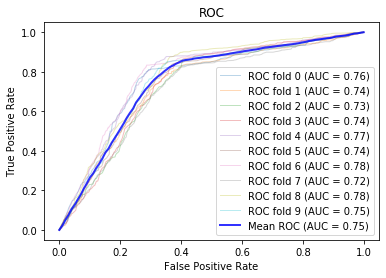

Accuracy = 0.7326245847176079


In [41]:
## finally traning the SVM 

image_metadata_df = pd.read_csv(METADATA_FILE);
array = image_metadata_df.values
X = array[:,0:3]
y = array[:,3]


cv = StratifiedKFold(n_splits=10)
svm_model = SVC(kernel='rbf', gamma=0.05, C=1.0)
aucs = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    svm_model.fit(X[train], y[train])
    figure = plot_roc_curve(svm_model, X[test], y[test],
                            name='ROC fold {}'.format(i),
                            alpha=0.3, 
                            lw=1,
                            ax=ax)
    interp_tpr = interp(mean_fpr, figure.fpr, figure.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(figure.roc_auc)
    print('AUC = ', end =""),
    print(float(figure.roc_auc))


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
print('Mean AUC = ', end ="")
print(mean_auc)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f)' % (mean_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)


ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC")
ax.legend(loc="lower right")
plt.show()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=0)
svm_model = SVC(kernel='rbf', gamma=0.1, C=1.0)
svm_model.fit(x_train, y_train)
predictions = svm_model.predict(x_test)
score = svm_model.score(x_test, y_test)
print('Accuracy =',score)

### Logistic Regression

In [0]:
## imports 
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
import numpy as np
import pandas as pd
from numpy import interp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

AUC = 0.7607636797016915
AUC = 0.7187631217423848
AUC = 0.7404661983916168
AUC = 0.7381497829777912
AUC = 0.7860680478312805
AUC = 0.7341965968948769
AUC = 0.7650417503314481
AUC = 0.7164905409231219
AUC = 0.7878211816654186
AUC = 0.7484251995470237
Mean AUC = 0.7495639166290029


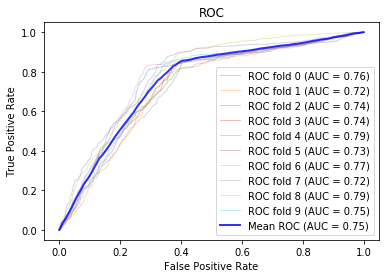

Accuracy = 0.7327574750830564


In [43]:


image_data = pd.read_csv(METADATA_FILE);
array = image_data.values
X = array[:,0:3]
y = array[:,3]
n_samples, n_features = X.shape


# 10 fold cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
classifier = LogisticRegression(max_iter=1000)
aucs = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    figure = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, figure.fpr, figure.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(figure.roc_auc)
    print('AUC = ', end =""),
    print(float(figure.roc_auc))


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
print('Mean AUC = ', end ="")
print(mean_auc)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f)' % (mean_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)


ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC")
ax.legend(loc="lower right")
plt.show()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=0)
classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)
score = classifier.score(x_test, y_test)
print('Accuracy =',score)